<a href="https://colab.research.google.com/github/mridul-eecs/fast_ai/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install duckduckgo_search
!pip install ipython-autotime
%load_ext autotime

In [5]:
from fastdownload import download_url
from duckduckgo_search import ddg_images
from fastcore.all import *
from tqdm import tqdm_notebook as tqdm

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
url= 'https://amazinganimalphotos.com/wp-content/uploads/2016/11/beautiful-birds.jpeg'
urls= search_images("bird photos")

Searching for 'bird photos'


### Download images using duckduckgo_search and fastdownload

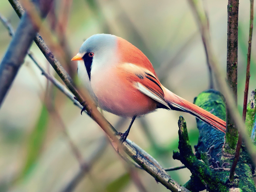

In [4]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [6]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in tqdm(searches):
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

<ipython-input-6-4afc258e2319>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for o in tqdm(searches):


  0%|          | 0/2 [00:00<?, ?it/s]

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


### verify and remove failed downloads

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

### Training with dataloaders

In [15]:
from fastai.vision.augment import aug_transforms

dls= DataBlock(
    blocks= (ImageBlock, CategoryBlock),
    get_items= get_image_files,
    splitter= RandomSplitter(valid_pct= 0.2, seed= 123),
    get_y= parent_label,
    item_tfms= [Resize(192, method= "squish")],
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)



"""
Here what each of the DataBlock parameters means:

blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

get_items=get_image_files, 

To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).

splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

get_y=parent_label,

The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).

item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).
"""

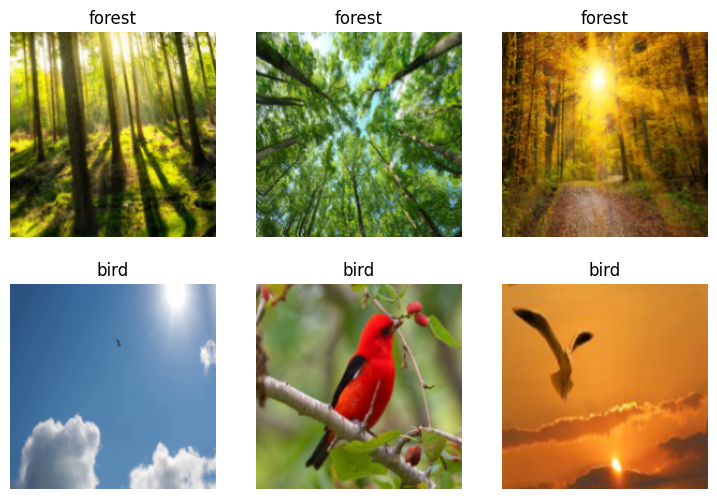

In [16]:
dls.show_batch(max_n=6)

In [17]:
learn = vision_learner(dls, resnext101_64x4d, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_64X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:16<00:00, 20.9MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.508942,0.234568,0.090909,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.051231,0.106389,0.030303,00:05
1,0.075232,0.079719,0.030303,00:05
2,0.061921,0.044951,0.000000,00:04


In [19]:
import pickle
with open("model.pickle", "wb") as file:
  pickle.dump(learn, file)

### load the model and predict

In [21]:
with open("model.pickle", "rb") as file:
  model= pickle.load(file)

In [27]:
is_bird,_,probs = model.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")
print(f"Probability it's a forest: {probs[1]:.4f}")

This is a: bird.
Probability it's a bird: 0.9937
Probability it's a forest: 0.0063
time: 153 ms (started: 2023-05-11 01:23:27 +00:00)
